In this lab you will do the following steps in order:

1. Explore and Load dataset.
2. Train [faster RCNN](https://towardsdatascience.com/faster-r-cnn-for-object-detection-a-technical-summary-474c5b857b46) for uno cards object detection.
3. Test the network.




Use GPU if available

In [ ]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DEVICE = torch.device("cuda:0" if train_on_gpu else "cpu")
print(DEVICE)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import re

1. Explore and Load dataset.

In [ ]:
!gdown "13IjqxWIVsP2bgPZP6sE9_VYGXMeu1MWI"
!unzip -q -n "/content/Uno Cards.v2-raw.voc.zip" -d data

Downloading...
From (original): https://drive.google.com/uc?id=13IjqxWIVsP2bgPZP6sE9_VYGXMeu1MWI
From (redirected): https://drive.google.com/uc?id=13IjqxWIVsP2bgPZP6sE9_VYGXMeu1MWI&confirm=t&uuid=c6598403-1708-46c3-8a9a-cdafe6438703
To: /content/Uno Cards.v2-raw.voc.zip
100% 350M/350M [00:04<00:00, 79.1MB/s]


Setup of the training procedure

In [ ]:
import torch
BATCH_SIZE = 8 # increase / decrease according to GPU memeory
RESIZE_TO = 416 # resize the image for training and transforms
NUM_EPOCHS = 1 # number of epochs to train for
NUM_WORKERS = 6 # originally 4
# training images and XML files directory
TRAIN_DIR = 'data/train'
# validation images and XML files directory
VALID_DIR = 'data/valid'
TEST_DIR = 'data/test'
# classes: 0 index is reserved for background
CLASSES = ['__background__','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']

NUM_CLASSES = len(CLASSES)
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = True
# location to save model and plots
OUT_DIR = 'outputs'

Utils

In [ ]:
from IPython.lib.display import exists
import albumentations as A
import cv2
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            os.makedirs("outputs",exist_ok=True)
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
def show_transformed_image(train_loader):
    """
    This function visualizes transformed images from the `train_loader`.

    It helps to verify if the transformations applied to the images and their
    corresponding labels are correct. The function only executes if the flag
    `VISUALIZE_TRANSFORMED_IMAGES` is set to `True` in the configuration file (`config.py`).

    Args:
        train_loader (torch.utils.data.DataLoader): The data loader containing
                                                  transformed training images and labels.
    """

    if len(train_loader) > 0:
        # Iterate over the data loader to get one batch of images and labels
        for i in range(1):
            images, targets = next(iter(train_loader))

            # Move images to the specified device (CPU or GPU)
            images = list(image.to(DEVICE) for image in images)

            # Move labels to the specified device and convert non-string elements to tensors on that device
            targets = [{k: v.to(DEVICE) for k, v in t.items() if not isinstance(v, str)} for t in targets]

            # Extract bounding boxes and labels from the first target in the batch
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)

            # Get the first image from the batch and convert it to a NumPy array for visualization
            sample = images[i].permute(1, 2, 0).cpu().numpy()

            # Draw bounding boxes and labels on the image
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                             (box[0], box[1]),  # Top-left corner coordinates
                             (box[2], box[3]),  # Bottom-right corner coordinates
                             (0, 0, 255), 2)    # Red color, thickness 2
                label_text = CLASSES[labels[box_num]]  # Get label text from label index
                cv2.putText(sample, label_text,
                            (box[0], box[1] - 10),  # Position above top-left corner
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)  # Font style, size, color, thickness

            # Display the image using matplotlib
            plt.imshow(sample)
            plt.axis("off")  # Hide axes for cleaner visualization
            plt.show()

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    os.makedirs("outputs",exist_ok=True)
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/last_model.pth')
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

Prepare the dataset

Number of training images: 6295


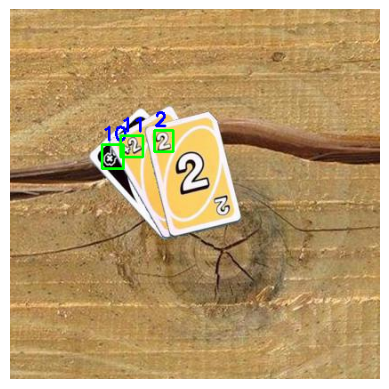

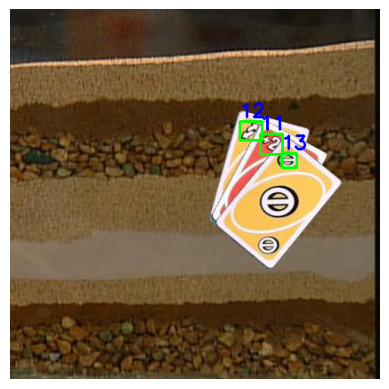

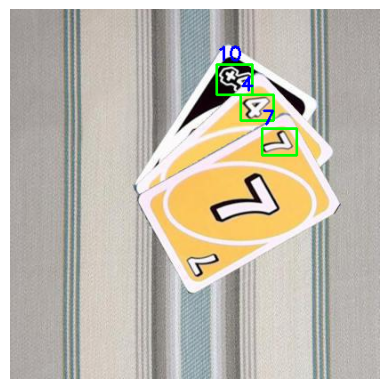

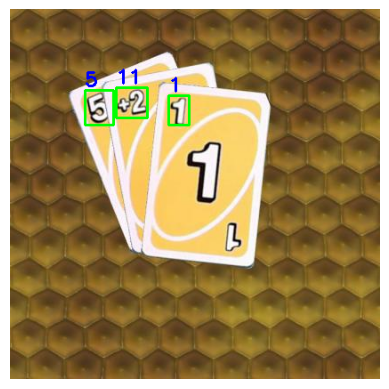

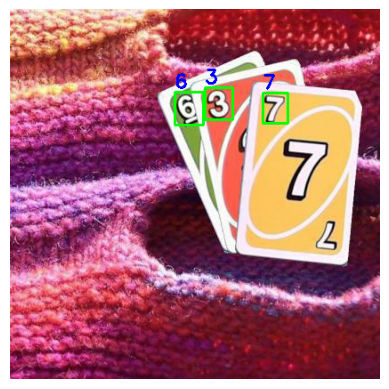

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))

            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)

            # resize the bounding boxes according to the desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        target["name"]=image_name
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image_resized, target

    def __len__(self):
        return len(self.all_images)

# prepare the final datasets and data loaders
def create_train_dataset():
    train_dataset = CustomDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
    return train_dataset
def create_valid_dataset():
    valid_dataset = CustomDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
    return valid_dataset
def create_test_dataset():
    valid_dataset = CustomDataset(TEST_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
    return valid_dataset
def create_train_loader(train_dataset, num_workers=0):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=0, batch_size=BATCH_SIZE):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return valid_loader

dataset = CustomDataset(
    TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
)
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    image=image*255
    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
    image=image.astype(np.uint8)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.figure()
NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)

Model setup. [Faster-rcnn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html?highlight=fasterrcnn_resnet50_fpn)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):

    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

2. Train and validate


In [ ]:
import torch
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
plt.style.use('ggplot')

def train(train_data_loader, model):
    """
    This function trains the model on the provided training data loader.

    Args:
        train_data_loader (torch.utils.data.DataLoader): The data loader containing training images and targets.
        model (torch.nn.Module): The deep learning model to be trained.

    Returns:
        list: A list containing the training loss values for each iteration.
    """

    print('Training')

    global train_itr  # Assuming this tracks the current training iteration (potentially for logging)
    global train_loss_list  # Assuming this stores training loss values (potentially for monitoring)

    # Initialize tqdm progress bar for training loop visualization
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        # Clear optimizer gradients for each iteration
        optimizer.zero_grad()

        # Get images and targets from the current batch
        images, targets = data

        # Move images to the specified device (CPU or GPU)
        images = list(image.to(DEVICE) for image in images)

        # Move targets to the specified device and convert non-string elements to tensors on that device
        targets = [{k: v.to(DEVICE) for k, v in t.items() if not isinstance(v, str)} for t in targets]

        # Forward pass through the model to get loss dictionary
        loss_dict = model(images, targets)

        # Calculate the total loss by summing losses from the loss dictionary
        losses = sum(loss for loss in loss_dict.values())

        # Extract the loss value as a scalar
        loss_value = losses.item()

        # Append the loss value to the training loss list
        train_loss_list.append(loss_value)

        # Send the loss value to a visualization tool (e.g., TensorBoard) if applicable
        train_loss_hist.send(loss_value)  # Assuming train_loss_hist is a visualization tool

        # Perform backward pass to calculate gradients
        losses.backward()

        # Update model weights using optimizer step
        optimizer.step()

        # Update training iteration counter (potentially for logging)
        train_itr += 1

        # Update progress bar with current loss value
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list


def validate(valid_data_loader, model):
    """
    This function validates the model's performance on the provided validation data loader.

    Args:
        valid_data_loader (torch.utils.data.DataLoader): The data loader containing validation images and targets.
        model (torch.nn.Module): The deep learning model to be validated.

    Returns:
        list: A list containing the validation loss values for each iteration.
    """

    print('Validating')

    global val_itr  # Assuming this tracks the current validation iteration (potentially for logging)
    global val_loss_list  # Assuming this stores validation loss values (potentially for monitoring)

    # Initialize tqdm progress bar for validation loop visualization
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        # Get images and targets from the current batch
        images, targets = data

        # Move images to the specified device (CPU or GPU)
        images = list(image.to(DEVICE) for image in images)

        # Move targets to the specified device and convert non-string elements to tensors on that device
        targets = [{k: v.to(DEVICE) for k, v in t.items() if not isinstance(v, str)} for t in targets]

        # Disable gradient calculation for validation (saves memory and computation)
        with torch.no_grad():
            # Forward pass through the model to get loss dictionary
            loss_dict = model(images, targets)

            # Calculate the total loss by summing losses from the loss dictionary
            losses = sum(loss for loss in loss_dict.values())

            # Extract the loss value as a scalar
            loss_value = losses.item()

            # Append the loss value to the validation loss list
            val_loss_list.append(loss_value)

            # Send the loss value to a visualization tool (e.g., TensorBoard) if applicable
            val_loss_hist.send(loss_value)  # Assuming val_loss_hist is a visualization tool

            # Update validation iteration counter (potentially for logging)
            val_itr += 1

        # Update progress bar with current loss value
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return val_loss_list

Training code

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

Number of training samples: 6295
Number of validation samples: 1798

Number of test samples: 899



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 145MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


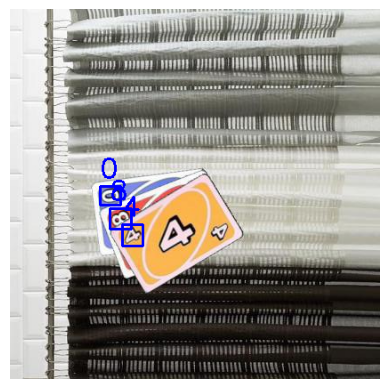


EPOCH 1 of 1
Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch #1 train loss: 0.341
Epoch #1 validation loss: 0.165
Took 23.126 minutes for epoch 0

Best validation loss: 0.1650236549642351

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...


In [ ]:
if __name__ == '__main__':
    train_dataset = create_train_dataset()
    valid_dataset = create_valid_dataset()
    test_dataset = create_test_dataset()
    train_loader = create_train_loader(train_dataset, NUM_WORKERS)
    valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
    test_loader = create_valid_loader(test_dataset, NUM_WORKERS, batch_size=1)
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(valid_dataset)}\n")
    print(f"Number of test samples: {len(test_dataset)}\n")
    # initialize the model and move to the computation device
    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    # get the model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    # define the optimizer
    optimizer = torch.optim.Adam(params, lr=0.0001)
    # initialize the Averager class
    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1
    # train and validation loss lists to store loss values of all...
    # ... iterations till ena and plot graphs for all iterations
    train_loss_list = []
    val_loss_list = []
    # name to save the trained model with
    MODEL_NAME = 'model'
    # whether to show transformed images from data loader or not
    if VISUALIZE_TRANSFORMED_IMAGES:
        show_transformed_image(train_loader)
    # initialize SaveBestModel class
    save_best_model = SaveBestModel()
    # start the training epochs
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
        # reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()
        # start timer and carry out training and validation
        start = time.time()
        train_loss = train(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
        print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        # save the best model till now if we have the least loss in the
        # ... current epoch
        save_best_model(
            val_loss_hist.value, epoch, model, optimizer
        )
        # save the current epoch model
        save_model(epoch, model, optimizer)
        # save loss plot
        save_loss_plot(OUT_DIR, train_loss, val_loss)

        # sleep for 5 seconds after each epoch
        time.sleep(5)

Test the network

In [ ]:
def avg_iou(boxesa, boxesb, missing_penalizer):
    '''
    takes two lists of list as input: the real coordinates of the boxes and the
    predicted ones, they can have different lenght if not all the boxes are caught.

    The real and prediced bboxes are ordered differently, for this reason all boxes
    are confronted with each others and all the ious are computed. Then only the
    highest ious are saved.
    Missing penalizer controls the following:
    If enabled, when not all the boxes are caught some 0 ious are included, missing
    boxes highly decrease the avg iou then.
    If disabled, it checks the iou only of the caught boxes.
    '''
    if missing_penalizer:
      n_boxes = len(boxesa)
    else:
      n_boxes = len(boxesb)
    ious = []

    for real_bbox in boxesa:
      for pred_bbox in boxesb:
        x1_min, y1_min, x1_max, y1_max = real_bbox
        x2_min, y2_min, x2_max, y2_max = pred_bbox

        # Calculate the coordinates of the intersection rectangle
        x_inter_min = max(x1_min, x2_min)
        y_inter_min = max(y1_min, y2_min)
        x_inter_max = min(x1_max, x2_max)
        y_inter_max = min(y1_max, y2_max)

        # Calculate the area of the intersection
        inter_width = max(0, x_inter_max - x_inter_min + 1)
        inter_height = max(0, y_inter_max - y_inter_min + 1)
        intersection_area = inter_width * inter_height

        # Calculate the areas of the bounding boxes
        boxa_area = (x1_max - x1_min + 1) * (y1_max - y1_min + 1)
        boxb_area = (x2_max - x2_min + 1) * (y2_max - y2_min + 1)

        # Calculate the area of union
        union_area = boxa_area + boxb_area - intersection_area

        # Calculate and return IOU
        iou = intersection_area / union_area
        ious.append(iou)

    ious = (sorted(ious)[-n_boxes:])
    #print(ious)
    return np.mean(ious)

In [ ]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time
from copy import copy


# load the best model and trained weights
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8                                                   ##
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0
os.makedirs("inference_outputs/images",exist_ok=True)
# initialize tqdm progress bar
prog_bar = tqdm(test_loader, total=len(test_loader))

ious = {}


for i, data in enumerate(prog_bar):
    image, target = data
    image=image[0]
    target=target[0]
    '''
  target contains the coordinates of the boxes, the labels, area, etc...
    '''
    orig_image = np.array(image).transpose(1,2,0)
    image=image.to(DEVICE)

    # get the image file name for saving output later on
    image_name = target["name"]
    bbox=target["boxes"]                                 # TARGET BOUDING BOXES

    # add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))               # contains multiple boxes, labels and confidence scores
    end_time = time.time()
    print(outputs)
    # get the current fps
    fps = 1 / (end_time - start_time)                   # metric used to compute how fast that is?
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    # Check if there are any detected bounding boxes
    if len(outputs[0]['boxes']) != 0:
        # Get boxes and scores from the output dictionary
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()

        # Filter boxes based on a detection threshold (confidence score)
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()  # Copy boxes for drawing                # PREDICTED BOUNDING BOXES filtered only for confidence scores higher than n, could be changed

        #print(f"Average IoU: {avg_iou(bbox.tolist(),draw_boxes.tolist(), True)}")
        ious[image_name]=avg_iou(bbox.tolist(),draw_boxes.tolist(), True)

        # Get predicted class names based on class indices
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Loop through detected bounding boxes and draw them on the image
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]

            #print(draw_boxes[j])
            #print(bbox[j])

            # Draw a green rectangle around the bounding box
            cv2.rectangle(orig_image, (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])), (0, 255, 0), 2)

            # Write the predicted class name above the bounding box
            cv2.putText(orig_image, class_name, (int(box[0]), int(box[1] - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        # Display the image with bounding boxes and class names using matplotlib
        plt.imshow(orig_image)
        plt.title(f"Average IoU: {round(avg_iou(bbox.tolist(),draw_boxes.tolist(), True), 3)}")   # set avg iou as title
        plt.axis("off")

        # Save the image with bounding boxes to a specified directory
        plt.savefig(f"inference_outputs/images/{image_name}.jpg", bbox_inches="tight",pad_inches=0)
        plt.show()
        # cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", np.uint8(orig_image[:,:,::-1]*255))
        # Create a new figure for potentially further plotting needs
        plt.figure()
    print(f"Image {i+1} done...")
    print('-'*50)  # Print a separator for clarity



print('TEST PREDICTIONS COMPLETE')

# Close any open OpenCV windows
cv2.destroyAllWindows()

# Calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


In [ ]:
dict(sorted(ious.items(), key=lambda item: item[1], reverse=False))

{'969236719_jpg.rf.6ab5cc92e4ad235bab54837dac209025.jpg': 0.6601463242075122,
 '689327179_jpg.rf.2bdfd6a1a62b29e364ba3b09cc511466.jpg': 0.7118339343845235,
 '534242678_jpg.rf.a53550ac278a9511d81aed0f274f488d.jpg': 0.7784572816033969,
 '999167231_jpg.rf.52aea68be3319a9c476cfac716319c76.jpg': 0.7979583581738257,
 '169352591_jpg.rf.386772b1737d1c49a03fe8e57157eae8.jpg': 0.8038883198496852,
 '956843142_jpg.rf.fc418602edb0ed466230452e6cd6e278.jpg': 0.8195008652019721,
 '049659472_jpg.rf.8baceeadef052e642bfe5b39b47263d3.jpg': 0.8215694947447229,
 '268574229_jpg.rf.b9cec5f50e45c4cecf5c9039bc7d631a.jpg': 0.8239128113236309,
 '294698188_jpg.rf.c1681febb12a6cd8bb57d468fbf98099.jpg': 0.8314473307609199,
 '805959235_jpg.rf.6a5e40c40f15783361f3309f4396f87f.jpg': 0.8347023718636551,
 '496722585_jpg.rf.fa73c9635f79580639d9371c7b1f0d9f.jpg': 0.836786661334239,
 '931708385_jpg.rf.aceb557761eeabfe392f3432edebd8d5.jpg': 0.8370811259059933,
 '795794431_jpg.rf.2e645099ebf08eed15efb731904af30f.jpg': 0.83803

In [ ]:
dict(sorted(ious.items(), key=lambda item: item[1], reverse=True))

{'254974645_jpg.rf.97a1b7eb58297b610516e658dc57b31a.jpg': 0.963844138760576,
 '442492237_jpg.rf.71cc7aace552d797d0015345125996af.jpg': 0.9534678871110396,
 '329612360_jpg.rf.e92ce8a47bf6e57b0ffbf9212df2e0c6.jpg': 0.9471188969828169,
 '404410382_jpg.rf.c8a9e62614ced87a6dadf680e6e11167.jpg': 0.9410133920155811,
 '615247224_jpg.rf.e2210378f2ab03ff81f5a096a523740b.jpg': 0.9377585598851295,
 '677977647_jpg.rf.8eabfcd6b6c6f4f1e552de817a012c8e.jpg': 0.9349856769211607,
 '946866079_jpg.rf.dbd84d43b34977a66d7f403741bd9783.jpg': 0.9309966860507378,
 '090670860_jpg.rf.f3c05b22451d66e1f882c7f99d7833b9.jpg': 0.9278983776842019,
 '809374529_jpg.rf.25d9c5caadaa165c6f3618c3877fb81a.jpg': 0.922857812081182,
 '983897079_jpg.rf.a13690adbf70676c2ef612da5dc46f3a.jpg': 0.9217829002499266,
 '629796523_jpg.rf.4a83b56c0a35db923d21a44940150f28.jpg': 0.9203142536475869,
 '470769472_jpg.rf.079e43d8496caa1966e1034b48fc59d9.jpg': 0.9197236882642024,
 '752969688_jpg.rf.ad6e6dbc134f81b00fa6751d0d79e66e.jpg': 0.919715

In [ ]:
values = ious.values()

In [ ]:
mean_value = sum(values) / len(values)

In [ ]:
mean_value

0.877709308274409

**ASSIGNMENT**

Display some images in the test set with the highest and lowest Intersection over Union (IoU) scores. Additionally, attempt to provide insights into why the model may encounter difficulties in detecting certain images.